In [21]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16
from tensorboard import notebook
from tensorflow import keras 
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

100%|██████████| 186/186 [00:00<00:00, 195.74it/s]


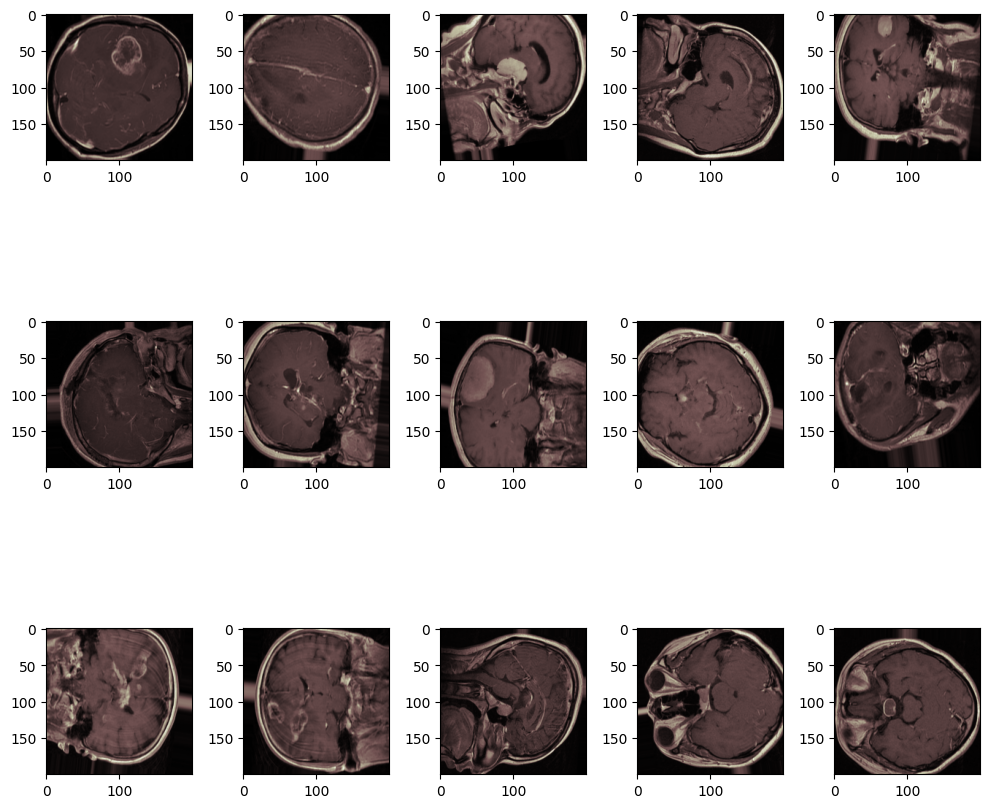

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [22]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
import warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"


def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=3):
    
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

   
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')


    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


In [4]:
net = SqueezeNet(include_top=None, weights=None, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-12-09 17:20:32.752471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 17:20:33.063570: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c3:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 99, 99, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 relu_conv1 (Activation)        (None, 99, 99, 64)   0           ['conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 49, 49, 64)   0           ['relu_conv1[0][0]']         

In [5]:
tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-ARM-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

Epoch 1/50


2023-12-09 17:20:43.028221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-09 17:20:43.628669: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-09 17:20:43.628702: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-09 17:20:43.628893: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-09 17:20:44.095993: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.4033
Epoch 1: saving model to model-ARM-Net.h5
Epoch 1: 8.10 seconds
264/264 [==============================] - 8s 18ms/step - loss: 1.0542 - accuracy: 0.4033 - val_loss: 0.9333 - val_accuracy: 0.5209 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.9083 - accuracy: 0.5322
Epoch 2: saving model to model-ARM-Net.h5
Epoch 2: 3.79 seconds
264/264 [==============================] - 4s 14ms/step - loss: 0.9086 - accuracy: 0.5322 - val_loss: 0.8880 - val_accuracy: 0.5332 - lr: 1.0000e-04
Epoch 3/50
264/264 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.5487
Epoch 3: saving model to model-ARM-Net.h5
Epoch 3: 3.77 seconds
264/264 [==============================] - 4s 14ms/step - loss: 0.8716 - accuracy: 0.5487 - val_loss: 0.8758 - val_accuracy: 0.5617 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - loss: 0.8381 - accur

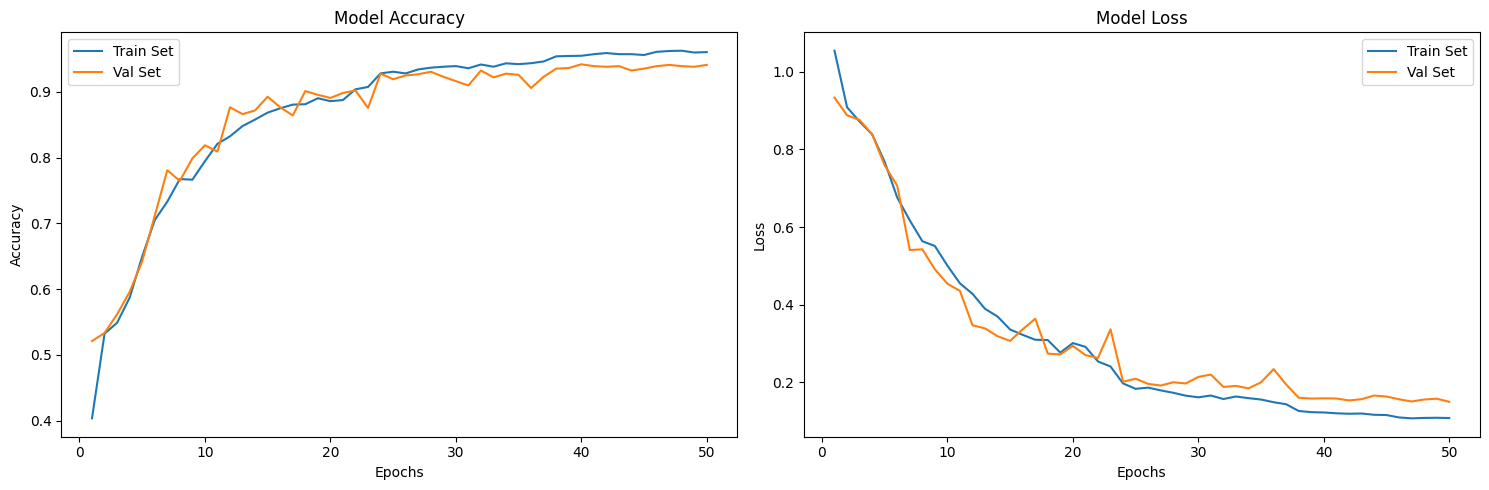

In [6]:
draw_curve(history)

20/20 [==============================] - 0s 6ms/step - loss: 0.2398 - accuracy: 0.9235
Test Accuracy:  92.35
              precision    recall  f1-score   support

      glioma     0.9600    0.9231    0.9412       286
  meningioma     0.8483    0.8662    0.8571       142
   pituitary     0.9278    0.9677    0.9474       186

    accuracy                         0.9235       614
   macro avg     0.9120    0.9190    0.9152       614
weighted avg     0.9244    0.9235    0.9236       614



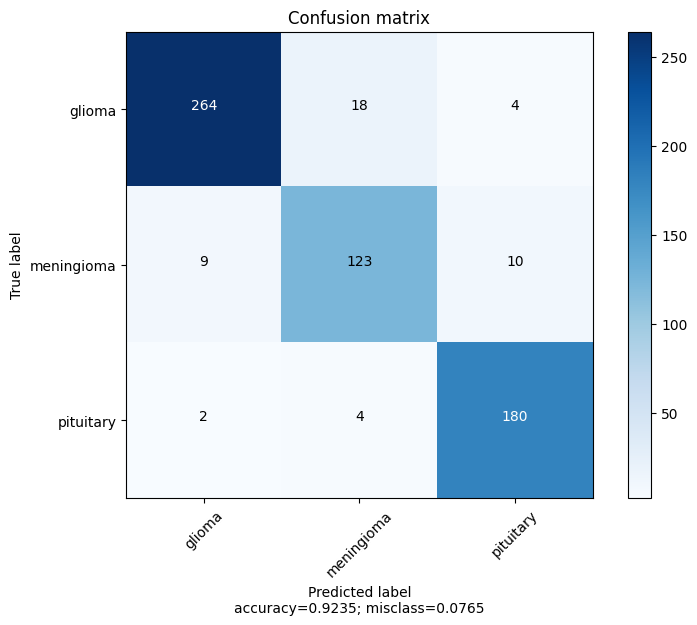

In [7]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [8]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 195.93it/s]


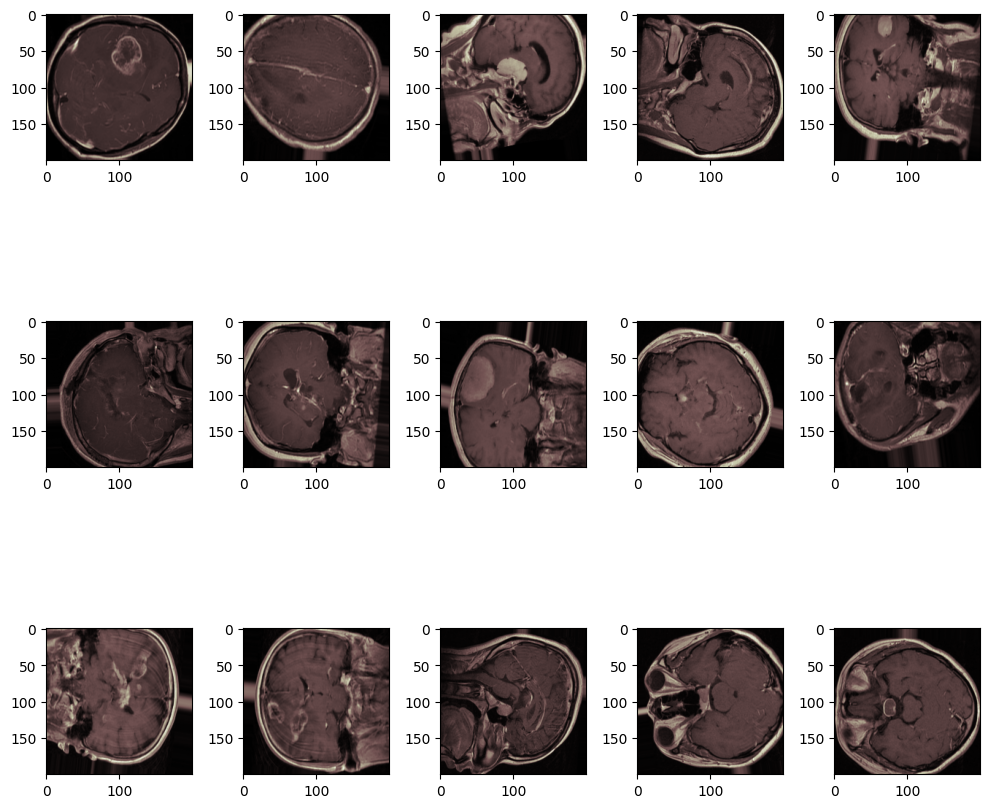

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
260/264 [============================>.] - ETA: 0s - loss: 1.0746 - accuracy: 0.3926
Epoch 1: saving model to model-SqueezeNet.h5
Epoch 1: 5.79 seconds
264/264 [==============================] - 6s 17ms/step - loss: 1.0741 - accuracy: 0.3936 - val_loss: 0.9992 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.9655 - accuracy: 0.5043
Epoch 2: saving model to model-SqueezeNet.h5
Epoch 2: 4.02 seconds
264/264 [==============================] - 4s 15ms/step - loss: 0.9652 - accuracy: 0.5046 - val_loss: 0.9305 - val_accuracy: 0.5275 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.8641 - accuracy: 0.5976
Epoch 3: saving model to model-SqueezeNet.h5
Epoch 3: 3.83 seconds
264/264 [==============================] - 4s 15ms/step - loss: 0.8642 - accuracy: 0.5971 - val_loss: 0.7946 - val_accuracy: 0.6186 - lr: 1.0000e-04
Epoc

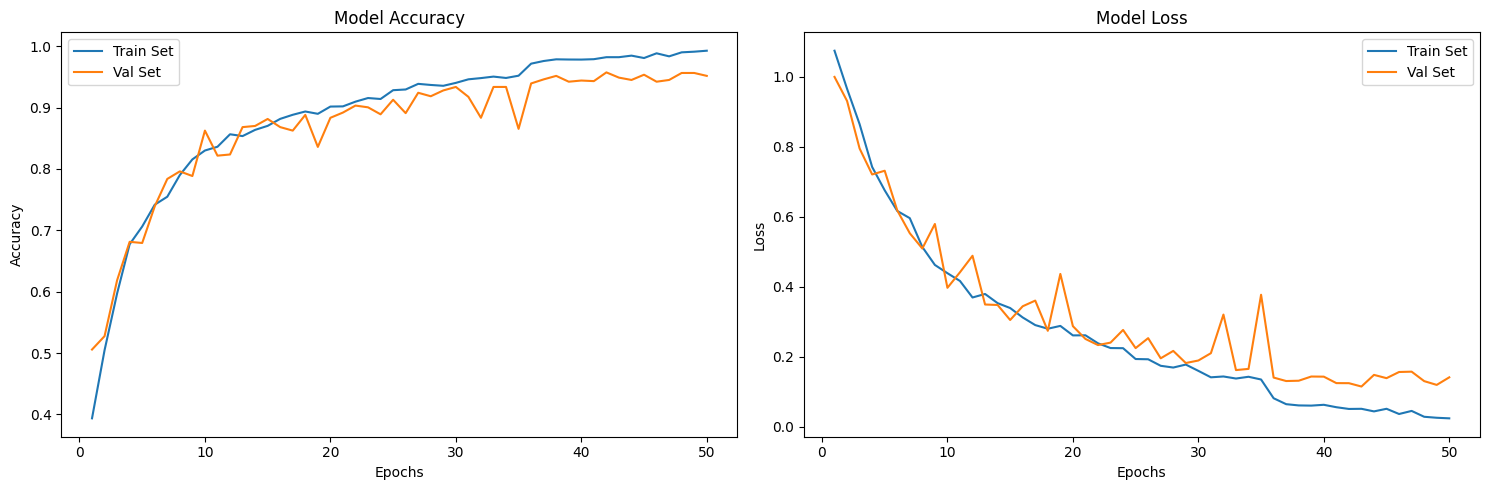

20/20 [==============================] - 0s 6ms/step - loss: 0.2661 - accuracy: 0.9332
Test Accuracy:  93.32
              precision    recall  f1-score   support

      glioma     0.9704    0.9161    0.9424       286
  meningioma     0.8733    0.9225    0.8973       142
   pituitary     0.9278    0.9677    0.9474       186

    accuracy                         0.9332       614
   macro avg     0.9238    0.9355    0.9290       614
weighted avg     0.9350    0.9332    0.9335       614



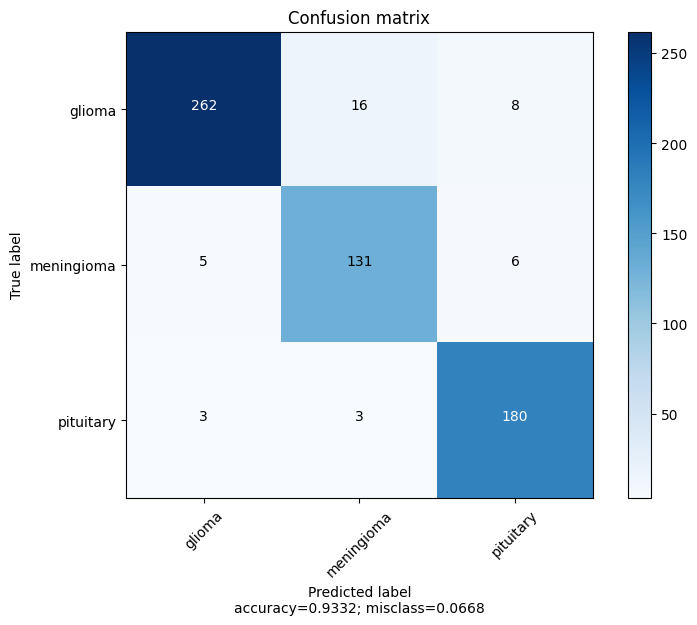

In [11]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = SqueezeNet(include_top=None, weights=None, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-SqueezeNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 196.06it/s]


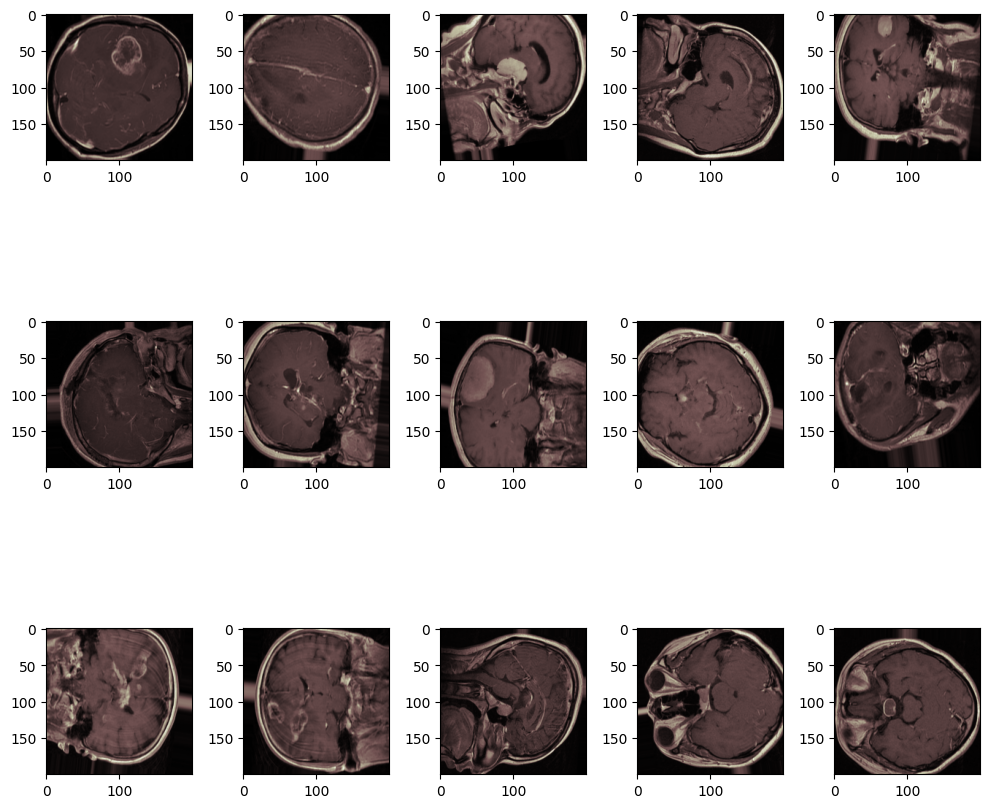

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
260/264 [============================>.] - ETA: 0s - loss: 1.0976 - accuracy: 0.3513
Epoch 1: saving model to model-SqueezeNet.h5
Epoch 1: 5.20 seconds
264/264 [==============================] - 5s 16ms/step - loss: 1.0976 - accuracy: 0.3513 - val_loss: 1.0988 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 1.0786 - accuracy: 0.3810
Epoch 2: saving model to model-SqueezeNet.h5
Epoch 2: 3.68 seconds
264/264 [==============================] - 4s 14ms/step - loss: 1.0784 - accuracy: 0.3812 - val_loss: 1.0584 - val_accuracy: 0.3937 - lr: 1.0000e-04
Epoch 3/50
262/264 [============================>.] - ETA: 0s - loss: 0.9854 - accuracy: 0.4867
Epoch 3: saving model to model-SqueezeNet.h5
Epoch 3: 3.83 seconds
264/264 [==============================] - 4s 15ms/step - loss: 0.9852 - accuracy: 0.4870 - val_loss: 0.9246 - val_accuracy: 0.5522 - lr: 1.0000e-04
Epoc

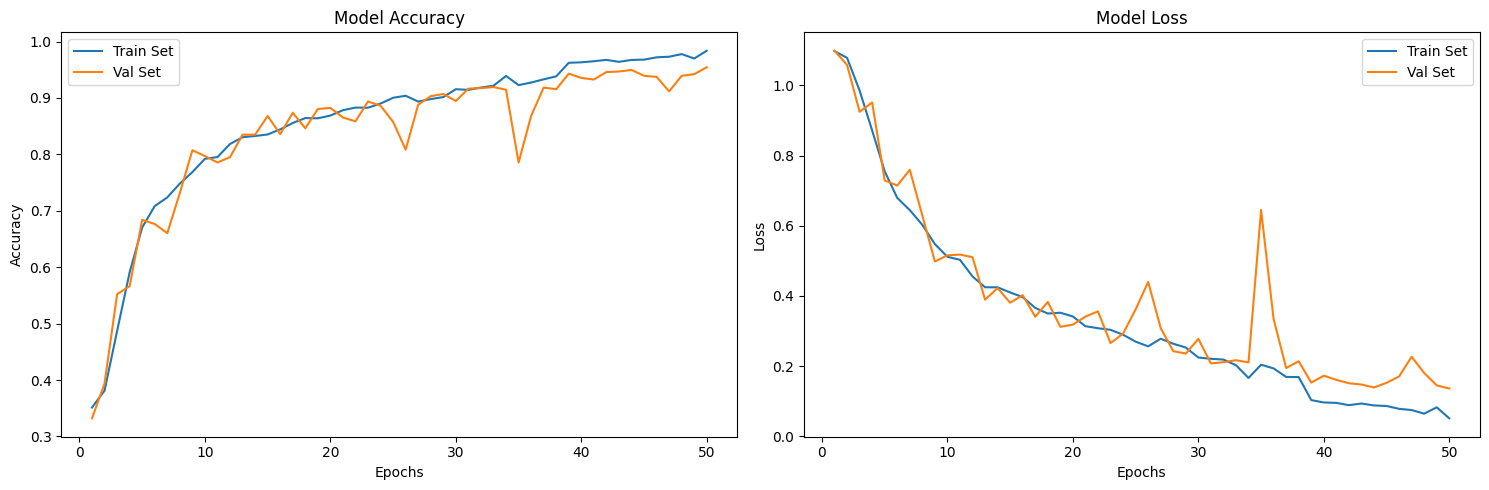

20/20 [==============================] - 0s 6ms/step - loss: 0.2412 - accuracy: 0.9235
Test Accuracy:  92.35
              precision    recall  f1-score   support

      glioma     0.9308    0.9406    0.9357       286
  meningioma     0.9023    0.8451    0.8727       142
   pituitary     0.9271    0.9570    0.9418       186

    accuracy                         0.9235       614
   macro avg     0.9200    0.9142    0.9167       614
weighted avg     0.9231    0.9235    0.9230       614



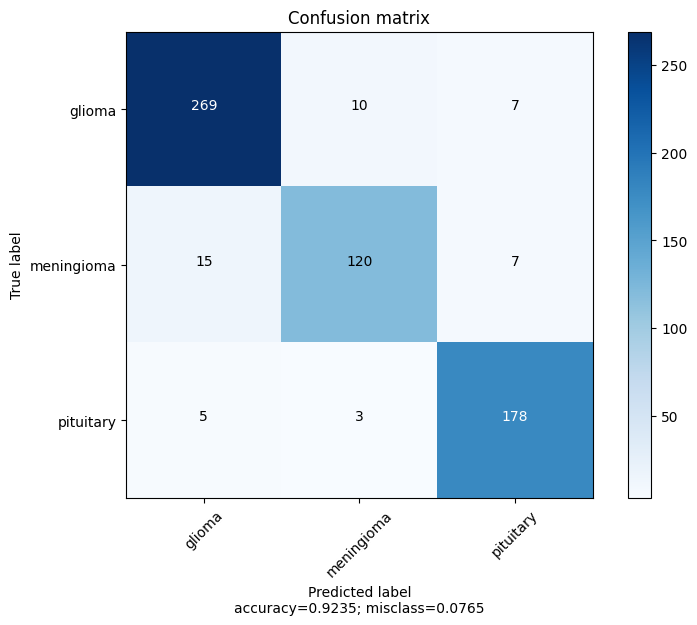

In [14]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = SqueezeNet(include_top=None, weights=None, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-SqueezeNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 195.52it/s]


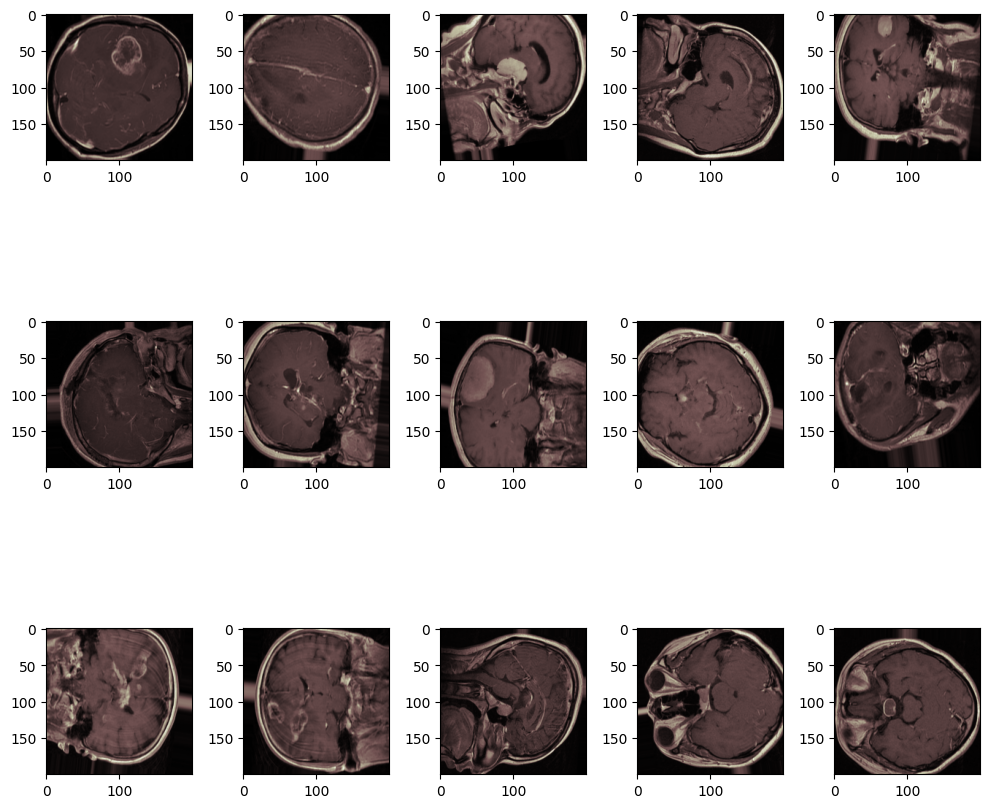

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 1.0759 - accuracy: 0.3776
Epoch 1: saving model to model-SqueezeNet.h5
Epoch 1: 5.37 seconds
264/264 [==============================] - 5s 17ms/step - loss: 1.0759 - accuracy: 0.3776 - val_loss: 0.9600 - val_accuracy: 0.5104 - lr: 1.0000e-04
Epoch 2/50
260/264 [============================>.] - ETA: 0s - loss: 0.9305 - accuracy: 0.5120
Epoch 2: saving model to model-SqueezeNet.h5
Epoch 2: 3.92 seconds
264/264 [==============================] - 4s 15ms/step - loss: 0.9290 - accuracy: 0.5130 - val_loss: 0.8974 - val_accuracy: 0.5484 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.8937 - accuracy: 0.5453
Epoch 3: saving model to model-SqueezeNet.h5
Epoch 3: 3.95 seconds
264/264 [==============================] - 4s 15ms/step - loss: 0.8934 - accuracy: 0.5455 - val_loss: 0.8823 - val_accuracy: 0.5427 - lr: 1.0000e-04
Epoc

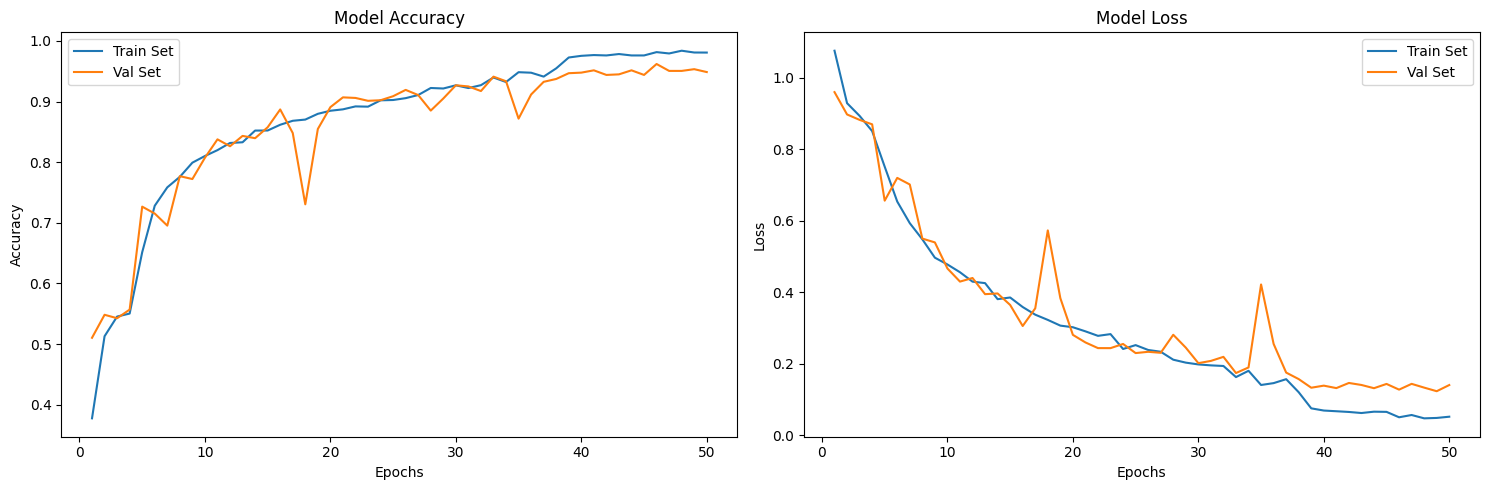

20/20 [==============================] - 0s 6ms/step - loss: 0.2419 - accuracy: 0.9365
Test Accuracy:  93.65
              precision    recall  f1-score   support

      glioma     0.9322    0.9615    0.9466       286
  meningioma     0.9154    0.8380    0.8750       142
   pituitary     0.9577    0.9731    0.9653       186

    accuracy                         0.9365       614
   macro avg     0.9351    0.9242    0.9290       614
weighted avg     0.9360    0.9365    0.9357       614



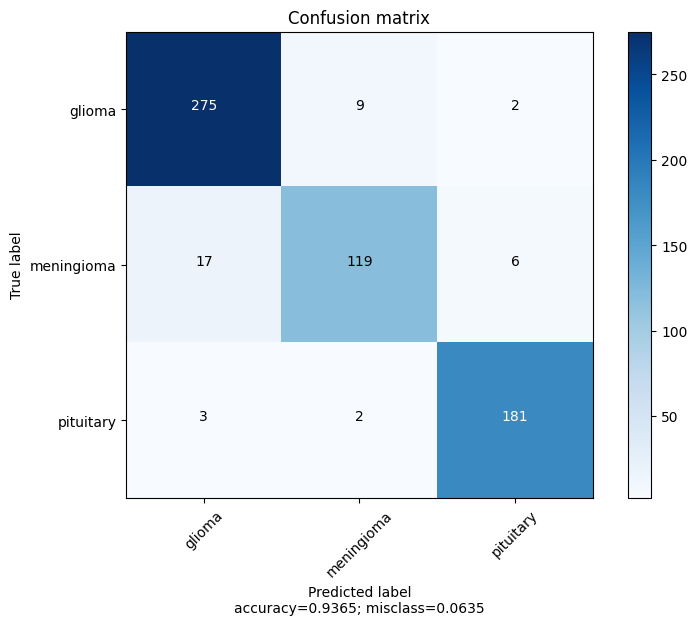

In [20]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = SqueezeNet(include_top=None, weights=None, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-SqueezeNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f

100%|██████████| 186/186 [00:00<00:00, 191.61it/s]


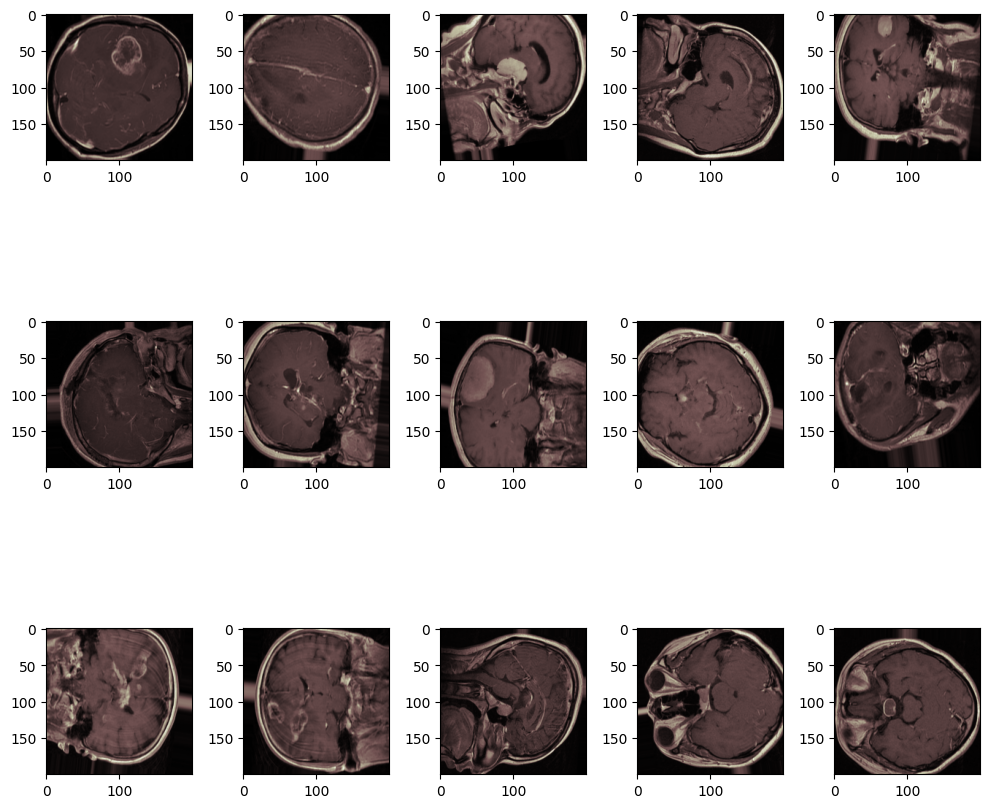

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
264/264 [==============================] - ETA: 0s - loss: 1.0677 - accuracy: 0.3873
Epoch 1: saving model to model-SqueezeNet.h5
Epoch 1: 5.16 seconds
264/264 [==============================] - 5s 16ms/step - loss: 1.0677 - accuracy: 0.3873 - val_loss: 1.0266 - val_accuracy: 0.4450 - lr: 1.0000e-04
Epoch 2/50
262/264 [============================>.] - ETA: 0s - loss: 0.9664 - accuracy: 0.4936
Epoch 2: saving model to model-SqueezeNet.h5
Epoch 2: 3.71 seconds
264/264 [==============================] - 4s 14ms/step - loss: 0.9662 - accuracy: 0.4938 - val_loss: 0.9328 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
261/264 [============================>.] - ETA: 0s - loss: 0.9395 - accuracy: 0.5197
Epoch 3: saving model to model-SqueezeNet.h5
Epoch 3: 3.80 seconds
264/264 [==============================] - 4s 14ms/step - loss: 0.9383 - accuracy: 0.5199 - val_loss: 0.9117 - val_accuracy: 0.5389 - lr: 1.0000e-04
Epoc

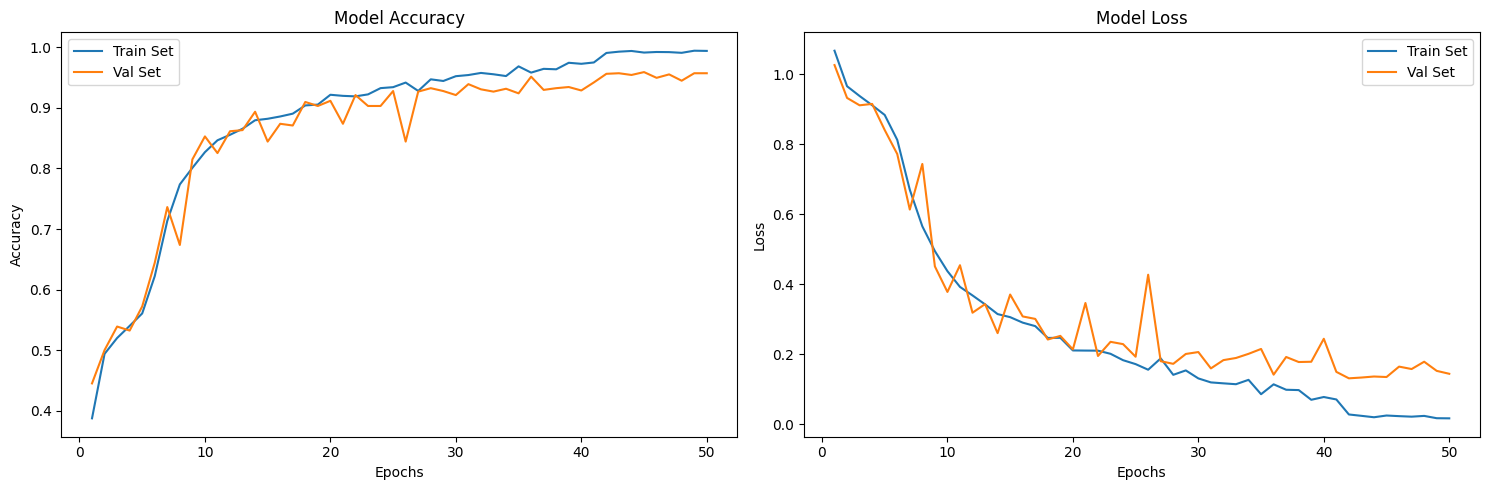

20/20 [==============================] - 0s 6ms/step - loss: 0.2420 - accuracy: 0.9414
Test Accuracy:  94.14
              precision    recall  f1-score   support

      glioma     0.9352    0.9580    0.9465       286
  meningioma     0.9118    0.8732    0.8921       142
   pituitary     0.9730    0.9677    0.9704       186

    accuracy                         0.9414       614
   macro avg     0.9400    0.9330    0.9363       614
weighted avg     0.9412    0.9414    0.9411       614



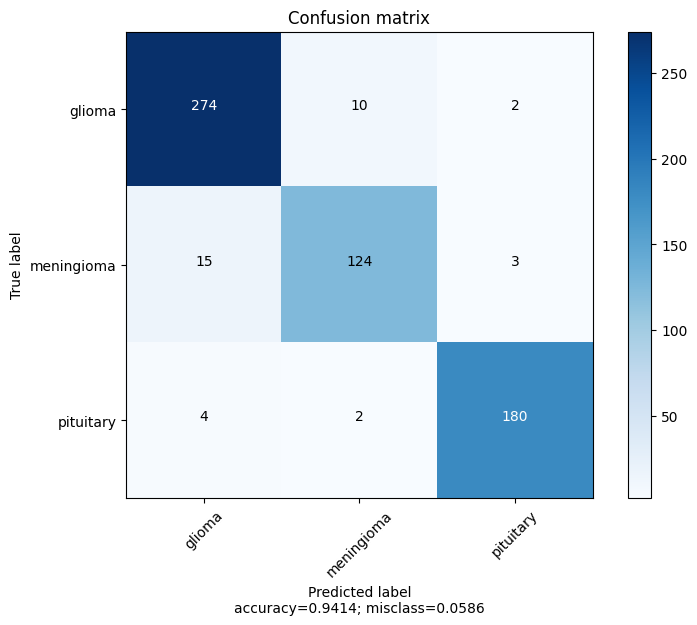

In [23]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = SqueezeNet(include_top=None, weights=None, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='model-SqueezeNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

%reset -f